<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۰) وارد کردن کتابخانه‌های مورد نیاز
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
در این نوتبوک هدف ما آموزش و تنظیم (Tuning) مدل <b>KNN</b> است.  
برای این کار به کتابخانه‌هایی نیاز داریم که:
<br>
- داده‌ها را بخوانیم و مدیریت کنیم (<code>pandas</code>، <code>numpy</code>)
<br>
- نمودار تحلیل نتایج رسم کنیم (<code>matplotlib</code>)
<br>
- داده را به بخش آموزش و اعتبارسنجی تقسیم کنیم (<code>train_test_split</code>)
<br>
- مدل KNN را بسازیم و پارامترهای آن را آزمایش کنیم (<code>KNeighborsClassifier</code>)
<br>
- و از معیار <code>F1-Score</code> برای ارزیابی استفاده کنیم.
</font>
</p>


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, make_scorer

<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۱) خواندن داده‌های پیش‌پردازش‌شده
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
در نوتبوک قبلی (پیش‌پردازش)، داده‌ها پاکسازی و مهندسی ویژگی روی آن انجام شده است و خروجی آن به صورت فایل ذخیره شده.  
در این نوتبوک فقط روی <b>مدل‌سازی</b> تمرکز می‌کنیم؛ بنابراین داده‌های آماده‌شده را از فایل می‌خوانیم تا:
<br>
- مراحل پروژه ما ماژولار و مرتب باشد،
<br>
- تکرار بی‌مورد کدها کم شود،
<br>
- و بتوانیم برای هر مدل یک نوتبوک جدا و تمیز داشته باشیم.
</font>
</p>


In [2]:
train_data = pd.read_csv("../../data/train_processed.csv")

train_data.head()


,ReserveStatus,Male,Price,From,To,Domestic,VehicleClass,TripReason,Cancel,TicketPerOrder,family,Departure_Created,DepartureMonth,Bus,InternationalPlane,Plane,Train,Discount
0,5,True,6565575.0,217.0,80.0,1,0.0,1,0,3,False,10,11,False,False,True,False,True
1,5,True,9500000.0,171.0,80.0,1,0.0,0,0,2,True,2,8,False,False,True,False,False
2,3,False,2000000.0,135.0,37.0,1,1.0,1,0,3,False,0,9,True,False,False,False,False
3,2,False,40000.0,64.0,85.0,1,1.0,0,0,6,True,0,6,False,False,False,True,False
4,3,True,1130000.0,68.0,244.0,1,1.0,0,0,1,False,1,6,True,False,False,False,False


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۲) جدا کردن ویژگی‌ها (X) و متغیر هدف (y)
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
برای آموزش هر مدل یادگیری ماشین، باید:
<br>
- ستون هدف (<code>TripReason</code>) را به عنوان <b>y</b> جدا کنیم،
<br>
- و بقیه ستون‌ها را به عنوان ویژگی‌ها (<b>X</b>) استفاده کنیم.
<br><br>
این جداسازی باعث می‌شود فرآیند مدل‌سازی شفاف باشد و اشتباهاً ستون هدف وارد ورودی مدل نشود.
</font>
</p>


In [3]:
X = train_data.drop(columns=["TripReason"])
y = train_data["TripReason"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_val.shape)


(80304, 17) (20076, 17)


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۳) تقسیم داده به Train و Validation
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
برای اینکه بتوانیم عملکرد مدل را به صورت واقعی ارزیابی کنیم، بخشی از داده را برای <b>اعتبارسنجی (Validation)</b> کنار می‌گذاریم.  
مدل فقط روی داده Train آموزش می‌بیند و سپس روی Validation تست می‌شود.
<br><br>
همچنین از <code>stratify</code> استفاده می‌کنیم تا نسبت کلاس‌های <code>TripReason</code> در Train و Validation مشابه باشد؛  
این کار به خصوص زمانی مهم است که داده نامتوازن باشد.
</font>
</p>


In [4]:
knn_pipe = Pipeline(steps=[
    ("scaler", MinMaxScaler()),
    ("model", KNeighborsClassifier())
])


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۴) ساخت Pipeline برای KNN (Scaling + Model)
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
الگوریتم <b>KNN</b> بر اساس <b>فاصله</b> بین نمونه‌ها تصمیم می‌گیرد.  
بنابراین اگر یکی از ویژگی‌ها (مثل Price) دامنه بسیار بزرگ‌تری نسبت به سایر ویژگی‌ها داشته باشد، روی فاصله‌ها اثر غالب می‌گذارد و مدل منحرف می‌شود.
<br><br>
به همین دلیل قبل از KNN معمولاً از <b>Scaling</b> استفاده می‌شود (مثل <code>MinMaxScaler</code>).
<br><br>
همچنین Scaling را داخل <code>Pipeline</code> قرار می‌دهیم تا:
<br>
- عملیات Scaling فقط روی Train fit شود (جلوگیری از نشت اطلاعات یا Data Leakage)،
<br>
- و در Cross-Validation به شکل کاملاً صحیح و خودکار انجام شود.
</font>
</p>


In [5]:
f1_macro = make_scorer(f1_score, average="macro")


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۵) معیار ارزیابی: Macro F1-Score
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
چون معیار داوری این تمرین <code>F1-Score</code> است، ما هم مدل‌ها را بر اساس همین معیار ارزیابی می‌کنیم.  
در این نوتبوک از <b>Macro-F1</b> استفاده می‌کنیم تا هر کلاس وزن برابر داشته باشد و اگر داده نامتوازن باشد، مدل فقط روی کلاس غالب خوب عمل نکند.
</font>
</p>


In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

k_values = list(range(1, 52, 2))  # 11,13,15,...,51
mean_scores = []
std_scores = []

for k in k_values:
    knn_pipe.set_params(model__n_neighbors=k)
    scores = cross_val_score(knn_pipe, X_train, y_train, cv=cv, scoring=f1_macro)
    mean_scores.append(scores.mean())
    std_scores.append(scores.std())

best_idx = int(np.argmax(mean_scores))
best_k = k_values[best_idx]

print("Best k:", best_k)
print("Best CV Macro-F1:", mean_scores[best_idx])


Best k: 1
Best CV Macro-F1: 0.7935061806381742


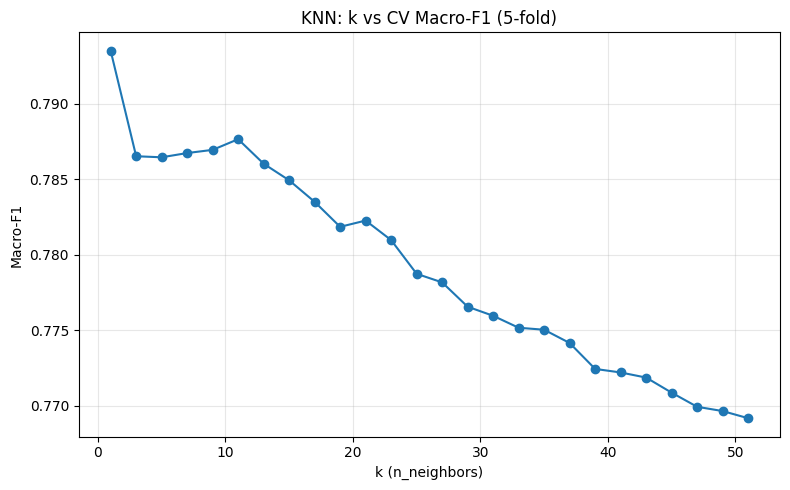

In [7]:
plt.figure(figsize=(8,5))
plt.plot(k_values, mean_scores, marker="o")
plt.title("KNN: k vs CV Macro-F1 (5-fold)")
plt.xlabel("k (n_neighbors)")
plt.ylabel("Macro-F1")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۶) تنظیم پارامتر k با Cross-Validation
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
پارامتر اصلی در KNN مقدار <code>k</code> (تعداد همسایه‌ها) است:
<br>
- k کوچک → مدل حساس‌تر و ممکن است overfit شود،
<br>
- k بزرگ → مدل نرم‌تر می‌شود ولی ممکن است underfit کند.
<br><br>
برای انتخاب k مناسب، به جای یک تست ساده، از <b>Cross-Validation</b> استفاده می‌کنیم تا نتیجه به یک تقسیم‌بندی خاص وابسته نباشد.  
این روش باعث می‌شود ارزیابی پایدارتر و قابل اعتمادتر باشد.
</font>
</p>


In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

k_values = list(range(1, 40, 2))
weights_list = ["uniform", "distance"]
metrics_list = ["minkowski"]  # پایه
p_list = [1, 2]  # 1=Manhattan, 2=Euclidean (وقتی metric=minkowski)

results = []

for w in weights_list:
    for p in p_list:
        for k in k_values:
            knn_pipe.set_params(
                model__n_neighbors=k,
                model__weights=w,
                model__metric="minkowski",
                model__p=p
            )
            scores = cross_val_score(knn_pipe, X_train, y_train, cv=cv, scoring=f1_macro)
            results.append({
                "k": k,
                "weights": w,
                "p": p,
                "cv_mean_f1": scores.mean(),
                "cv_std_f1": scores.std()
            })

results_df = pd.DataFrame(results).sort_values("cv_mean_f1", ascending=False)
results_df.head(10)


,k,weights,p,cv_mean_f1,cv_std_f1
54,29,distance,1,0.827431,0.001723
59,39,distance,1,0.827236,0.001476
57,35,distance,1,0.827214,0.001789
58,37,distance,1,0.827195,0.001459
53,27,distance,1,0.827170,0.001964
55,31,distance,1,0.826986,0.001861
52,25,distance,1,0.826957,0.001662
56,33,distance,1,0.826948,0.001651
51,23,distance,1,0.826831,0.001814
50,21,distance,1,0.826799,0.001807


In [9]:
best_row = results_df.iloc[0]
best_params = best_row.to_dict()
best_params


{'k': 29,
 'weights': 'distance',
 'p': 1,
 'cv_mean_f1': 0.8274309791972476,
 'cv_std_f1': 0.0017227756036436934}

<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۷) تحلیل دیداری نتایج (نمودار k vs F1)
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
بعد از محاسبه امتیاز برای k های مختلف، یک نمودار رسم می‌کنیم تا:
<br>
- روند تغییر عملکرد مدل نسبت به k را ببینیم،
<br>
- نقطه بهینه را بهتر تشخیص دهیم،
<br>
- و تصمیم انتخاب k را قابل دفاع‌تر کنیم (برای گزارش و فاز ارائه).
</font>
</p>


In [10]:
best_k = int(best_row["k"])
best_w = best_row["weights"]
best_p = int(best_row["p"])

final_knn = Pipeline(steps=[
    ("scaler", MinMaxScaler()),
    ("model", KNeighborsClassifier(
        n_neighbors=best_k,
        weights=best_w,
        metric="minkowski",
        p=best_p
    ))
])

final_knn.fit(X_train, y_train)
y_pred = final_knn.predict(X_val)

print("Validation Macro-F1:", f1_score(y_val, y_pred, average="macro"))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))


Validation Macro-F1: 0.835003386398653

Confusion Matrix:
 [[6876 1945]
 [1289 9966]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.78      0.81      8821
           1       0.84      0.89      0.86     11255

    accuracy                           0.84     20076
   macro avg       0.84      0.83      0.84     20076
weighted avg       0.84      0.84      0.84     20076



<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۹) آموزش بهترین مدل و ارزیابی نهایی
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
پس از انتخاب بهترین پارامترها با Cross-Validation، مدل نهایی را با همان تنظیمات آموزش می‌دهیم و سپس روی داده Validation ارزیابی می‌کنیم.
<br><br>
در این مرحله علاوه بر F1-Score، خروجی‌های زیر را هم نمایش می‌دهیم:
<br>
- <code>Confusion Matrix</code> برای بررسی نوع خطاها
<br>
- <code>Classification Report</code> برای Precision/Recall هر کلاس
<br><br>
این گزارش‌ها کمک می‌کنند نقاط ضعف مدل را دقیق‌تر تحلیل کنیم.
</font>
</p>


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۱۰) آموزش روی کل داده و پیش‌بینی داده تست
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
بعد از اینکه مدل را ارزیابی کردیم و از تنظیمات آن مطمئن شدیم، برای بیشترین استفاده از داده، مدل را روی کل داده آموزشی (Train + Validation) آموزش می‌دهیم.
<br><br>
سپس با این مدل، مقادیر <code>TripReason</code> را برای داده تست پیش‌بینی می‌کنیم و دیتافریم <code>submission</code> را می‌سازیم.
در نهایت فایل <code>submission.csv</code> ذخیره می‌شود تا در سامانه داوری بارگذاری شود.
</font>
</p>
